# Nickolaus White, Aditya Jain, Mark Carravallah, Stephen Lee, Hunter Pierson

# CMSE831

## Libraries

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import pandas as pd
import random
from PIL import Image
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import cross_val_predict, cross_val_score, GridSearchCV, StratifiedKFold, train_test_split
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, label_binarize, LabelBinarizer
from sklearn.utils import shuffle 
from sklearn.decomposition import PCA
from rpca import RobustPCA
from itertools import cycle
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras_tuner import HyperModel
from keras_tuner.tuners import Hyperband
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import warnings
warnings.filterwarnings("ignore")

## Functions

In [2]:
def checkUserId(id_input):
    
    path = 'dataset'
    imagePaths = [os.path.join(path, f) for f in os.listdir(path)] 
    
    for imagePath in imagePaths:
        id = os.path.split(imagePath)[-1].split(".")[1]
        if (id_input == id):
            return True

    return False

def fetchLastImageId(id_input):
    
    path = 'dataset'
    imagePaths = [os.path.join(path, f) for f in os.listdir(path)] 
    
    ids = []
    for imagePath in imagePaths:
        id = int(os.path.split(imagePath)[-1].split(".")[2])
        ids.append(id)

    return max(ids)

def unique(list1):
 
    list_set = set(list1)
    
    unique_list = (list(list_set))

    return unique_list

def getImagesAndLabels_Extraction(path):

    detector = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    
    imagePaths = [os.path.join(path, f) for f in os.listdir(path)]     
    faceSamples=[]
    ids = []

    for imagePath in imagePaths:
        
        PIL_img = Image.open(imagePath).convert('L') 
        img_numpy = np.array(PIL_img)
        
        id = os.path.split(imagePath)[-1].split(".")[1]
        
        faces = detector.detectMultiScale(img_numpy)
        
        for (x,y,w,h) in faces:
            faceSamples.append(img_numpy[y:y+h,x:x+w])
            ids.append(id)
        
    return faceSamples, ids


def getImagesAndLabels_Preview(path):

    imagePaths = [os.path.join(path, f) for f in os.listdir(path)]     
    faceSamples=[]
    ids = []

    for imagePath in imagePaths:
        
        PIL_img = Image.open(imagePath).convert('L') 
        img_numpy = np.array(PIL_img)
        
        id = os.path.split(imagePath)[-1].split(".")[1]
        
        faceSamples.append(img_numpy)
        ids.append(id)
        
    return faceSamples, ids

def addLabels(x, y):
    for i in range(len(x)):
        plt.text(i, y[i], round(y[i], 3), ha='center')

def random_augmentation(image):
    image = image.rotate(random.randint(-30, 30))

    if random.random() > 0.7:
        image = image.transpose(Image.FLIP_LEFT_RIGHT)

    if random.random() > 0.7:
        image = image.transpose(Image.FLIP_TOP_BOTTOM)

    if random.random() > 0.7:
        width, height = image.size
        left = random.randint(0, int(width * 0.1))
        top = random.randint(0, int(height * 0.1))
        right = width - random.randint(0, int(width * 0.1))
        bottom = height - random.randint(0, int(height * 0.1))
        image = image.crop((left, top, right, bottom))
        image = image.resize((width, height))

    return image

def augment_images(source_folder, target_folder):
    if not os.path.exists(target_folder):
        os.makedirs(target_folder)

    image_paths = [os.path.join(source_folder, f) for f in os.listdir(source_folder)]
    for image_path in image_paths:
        img = Image.open(image_path)
        augmented_img = random_augmentation(img)

        base_name = os.path.basename(image_path)
        new_filename = f"aug_{base_name}"
        augmented_img.save(os.path.join(target_folder, new_filename))


## Capture More Data (optional)

**Note**: Portions of the following code are a reference to Marcelo Rovai's [Real-Time Face Recognition: An End-To-End Project](https://towardsdatascience.com/real-time-face-recognition-an-end-to-end-project-b738bb0f7348).

### Convert the below cells to "Code" cells if wanting to add new facial photos to dataset. Webcam is needed for image capture.

## Load in Data

In [3]:
path = 'dataset'
faces, ids = getImagesAndLabels_Extraction(path)

i = 0
for image in faces:
    faces[i] = np.array(image, dtype=np.float32)
    faces[i] /= 255
    faces[i].resize((150, 150))
    i += 1
faces = np.array(faces)
faces0 = faces.copy()

## Exploratory Data Analysis

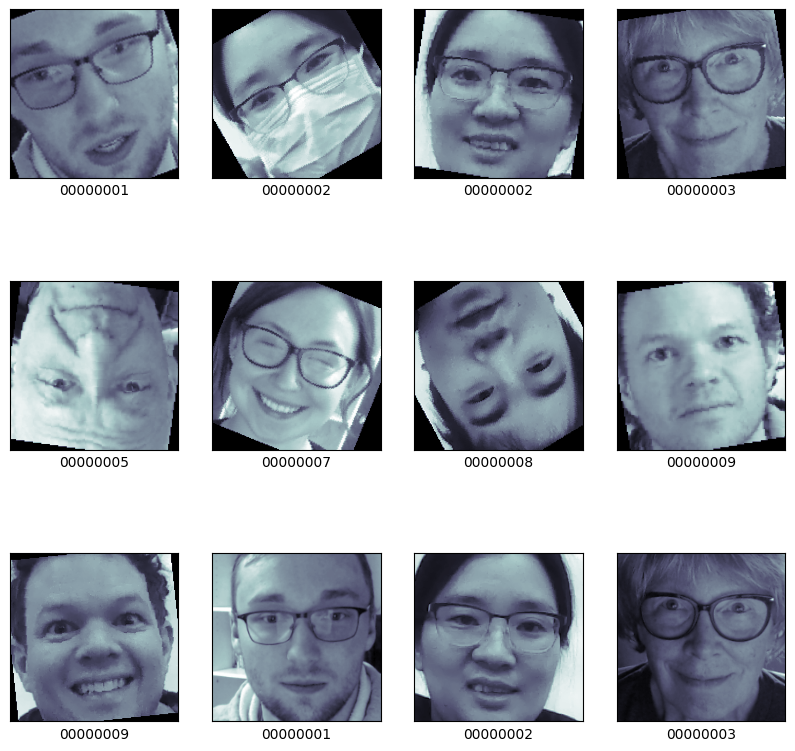

In [4]:
faces_p, ids_p = getImagesAndLabels_Preview(path)

fig, ax = plt.subplots(3, 4, figsize=(10, 10))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces_p[i*60], cmap="bone")
    axi.set(xticks=[], yticks=[], xlabel=ids_p[i*60])

In [5]:
uniqueIds = unique(ids)

data = {}
for x1 in uniqueIds:
    count = 0
    for x2 in ids:
        if (x1 == x2):
            count += 1
    data[x1] = count    
data    

{'00000001': 47,
 '00000007': 96,
 '00000008': 94,
 '00000006': 81,
 '00000003': 25,
 '00000009': 150,
 '00000005': 57,
 '00000002': 137}

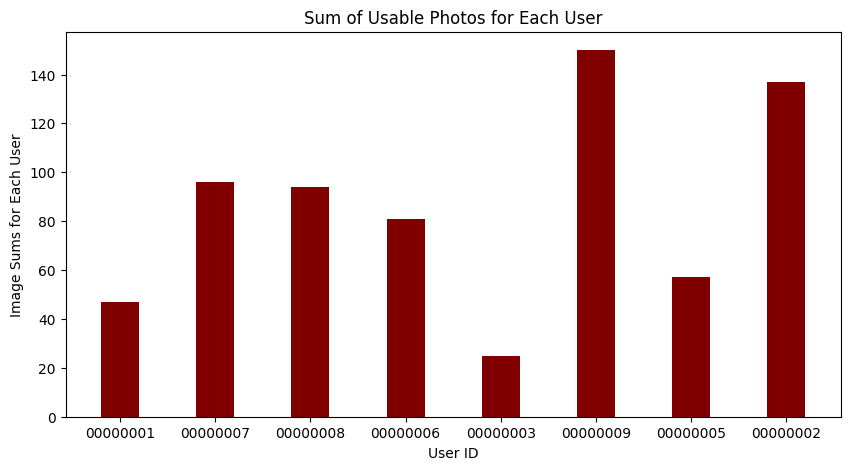

In [6]:
classes = list(data.keys())
sums = list(data.values())

fig = plt.figure(figsize = (10, 5))
plt.bar(classes, sums, color ='maroon', width = 0.4)
plt.xlabel("User ID")
plt.ylabel("Image Sums for Each User")
plt.title("Sum of Usable Photos for Each User")
plt.show()

## Create A Train & Test Set

In [4]:
faces0 = faces0.reshape(len(faces0), -1)
faces0.shape

X_train0, X_test0, Y_train0, Y_test0 = train_test_split(faces0, ids, random_state=42, test_size=0.3)

X_train0 = np.array(X_train0)
print(X_train0.shape)
Y_train0 = np.array(Y_train0)
print(Y_train0.shape)
X_test0 = np.array(X_test0)
print(X_test0.shape)
Y_test0 = np.array(Y_test0)
print(Y_test0.shape)

y = label_binarize(ids, classes=np.unique(ids))
n_classes = y.shape[1]

n_components = 0.95 

pca = PCA(n_components=n_components, whiten=True)
X_train_pca = pca.fit_transform(X_train0)
X_test_pca = pca.transform(X_test0)

print(X_train_pca.shape)
print(X_test_pca.shape)

n_components = 150
rpca = RobustPCA(n_components)
rpca.fit(X_train0)
X_train_rpca = rpca.transform(X_train0)
X_test_rpca = rpca.transform(X_test0)
print(X_train_rpca.shape)
print(X_test_rpca.shape)

(480, 22500)
(480,)
(207, 22500)
(207,)
(480, 155)
(207, 155)
[1] Tolerance: 1e-05	Current error: 0.12655546302263554
[2] Tolerance: 1e-05	Current error: 0.12263076137975529
[3] Tolerance: 1e-05	Current error: 0.12242894117424861
[4] Tolerance: 1e-05	Current error: 0.117224214449142
[5] Tolerance: 1e-05	Current error: 0.09405054822454999
[6] Tolerance: 1e-05	Current error: 0.06102416823313834
[7] Tolerance: 1e-05	Current error: 0.0337398690079484
[8] Tolerance: 1e-05	Current error: 0.016414794232794457
[9] Tolerance: 1e-05	Current error: 0.007354938701415819
[10] Tolerance: 1e-05	Current error: 0.003207988638360499
[11] Tolerance: 1e-05	Current error: 0.0013987352742468684
[12] Tolerance: 1e-05	Current error: 0.0006104098907670636
[13] Tolerance: 1e-05	Current error: 0.0002642055422425313
[14] Tolerance: 1e-05	Current error: 0.00011334216474160382
[15] Tolerance: 1e-05	Current error: 4.864644036221525e-05
[16] Tolerance: 1e-05	Current error: 2.0966101017623657e-05
[17] Tolerance: 1e-05

### Unique Images in Training Set

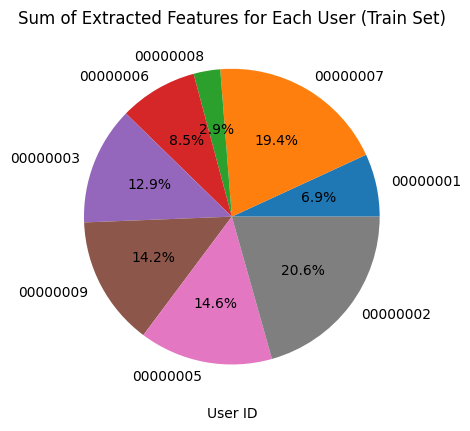

In [8]:
_, train_counts = np.unique(Y_train0, return_counts=True)
mylabels = unique(ids)

plt.pie(train_counts, labels=mylabels, autopct='%1.1f%%')
plt.xlabel("User ID")
plt.title("Sum of Extracted Features for Each User (Train Set)")
plt.show() 

### Unique Images in Testing Set

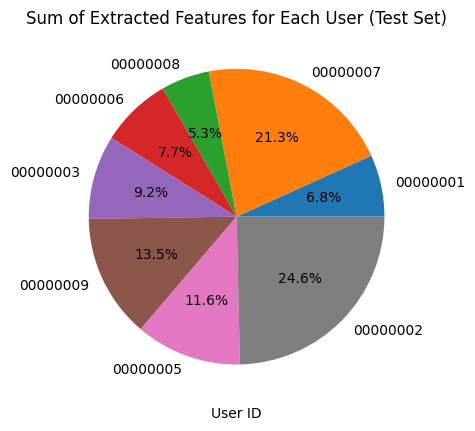

In [9]:
_, test_counts = np.unique(Y_test0, return_counts=True)
mylabels = unique(ids)

plt.pie(test_counts, labels=mylabels, autopct='%1.1f%%')
plt.xlabel("User ID")
plt.title("Sum of Extracted Features for Each User (Test Set)")
plt.show() 

## CNN modeling

In [10]:
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(ids)
labels = to_categorical(integer_encoded)
num_classes = len(np.unique(integer_encoded))

face_images = faces.copy()

face_images = face_images.reshape(-1, 150, 150, 1) 


### Intial model setup to understand the architecture and build baseline performance



Epoch 1/20


15/15 [==============================] - ETA: 0s - loss: 1.9654 - accuracy: 0.2438
Epoch 1: val_loss improved from inf to 1.84030, saving model to best_model.h5
15/15 [==============================] - 3s 103ms/step - loss: 1.9654 - accuracy: 0.2438 - val_loss: 1.8403 - val_accuracy: 0.3333 - lr: 1.0000e-04
Epoch 2/20
15/15 [==============================] - ETA: 0s - loss: 1.8494 - accuracy: 0.3167
Epoch 2: val_loss improved from 1.84030 to 1.72454, saving model to best_model.h5
15/15 [==============================] - 1s 88ms/step - loss: 1.8494 - accuracy: 0.3167 - val_loss: 1.7245 - val_accuracy: 0.4155 - lr: 1.0000e-04
Epoch 3/20
15/15 [==============================] - ETA: 0s - loss: 1.7252 - accuracy: 0.3458
Epoch 3: val_loss improved from 1.72454 to 1.56877, saving model to best_model.h5
15/15 [==============================] - 1s 87ms/step - loss: 1.7252 - accuracy: 0.3458 - val_loss: 1.5688 - val_accuracy: 0.4638 - lr: 1.0000e-04
Epoch 4/20
15/15 [============

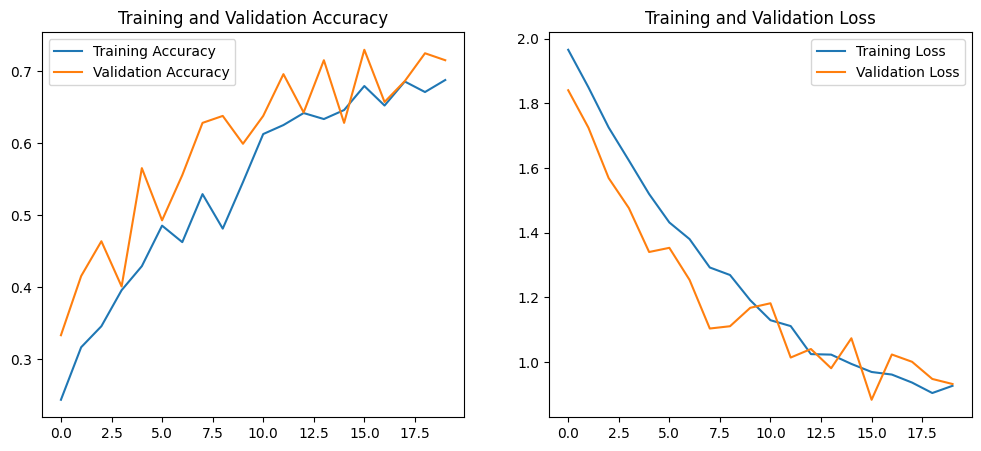

In [11]:
model = Sequential([
    Conv2D(16, (3, 3),1, activation='relu', input_shape=(150, 150, 1)),
    MaxPooling2D(),
    Conv2D(32, (3, 3),1, activation='relu'),
    MaxPooling2D(),
    Conv2D(16, (3, 3),1, activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(num_classes, activation='softmax')
])

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)

model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

augmenter = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

X_train, X_test, Y_train, Y_test = train_test_split(face_images, labels, test_size=0.3, random_state=42)

batch_size = 32 

history = model.fit(
    augmenter.flow(X_train, Y_train, batch_size=batch_size),
    validation_data=(X_test, Y_test),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=20,
    callbacks=[early_stopping, model_checkpoint, lr_scheduler]
)

test_loss, test_accuracy = model.evaluate(X_test, Y_test)
print(f"Test accuracy: {test_accuracy}")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


### Training the hyperband model

In [12]:
class CNNHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        model = Sequential()
        model.add(Conv2D(filters=hp.Int('conv_1_filter', min_value=16, max_value=64, step=16),
                         kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
                         activation='relu',
                         input_shape=self.input_shape))
        model.add(MaxPooling2D())
        model.add(Conv2D(filters=hp.Int('conv_2_filter', min_value=16, max_value=64, step=16),
                         kernel_size=hp.Choice('conv_2_kernel', values=[3, 5]),
                         activation='relu'))
        model.add(MaxPooling2D())
        model.add(Flatten())
        model.add(Dense(units=hp.Int('dense_units', min_value=128, max_value=512, step=128),
                        activation='relu'))
        model.add(Dense(self.num_classes, activation='softmax'))

        model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

        return model


hypermodel = CNNHyperModel(input_shape=(150, 150, 1), num_classes=num_classes)

tuner = Hyperband(
    hypermodel,
    objective='val_accuracy',
    max_epochs=10,
    directory='hyperband',
    project_name='face_recognition_V1'
)

tuner.search(X_train, Y_train, epochs=10, validation_data=(X_test, Y_test))
best_model = tuner.get_best_models(num_models=1)[0]
best_model_cnn = tuner.get_best_models(num_models=1)[0]
best_model.evaluate(X_test, Y_test)

Reloading Tuner from hyperband\face_recognition_V1\tuner0.json

7/7 [==============================] - 0s 14ms/step - loss: 0.5278 - accuracy: 0.9082


[0.5277712345123291, 0.9082125425338745]

### Tuner summary statistics

In [13]:
tuner.results_summary()

Results summary
Results in hyperband\face_recognition_V1
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0017 summary
Hyperparameters:
conv_1_filter: 16
conv_1_kernel: 5
conv_2_filter: 16
conv_2_kernel: 3
dense_units: 384
learning_rate: 0.0013743836586507334
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0012
Score: 0.9082125425338745

Trial 0024 summary
Hyperparameters:
conv_1_filter: 16
conv_1_kernel: 3
conv_2_filter: 16
conv_2_kernel: 3
dense_units: 128
learning_rate: 0.0011913083962274544
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0022
Score: 0.8840579986572266

Trial 0016 summary
Hyperparameters:
conv_1_filter: 16
conv_1_kernel: 3
conv_2_filter: 32
conv_2_kernel: 5
dense_units: 256
learning_rate: 0.0005264363579822869
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0015
Score: 0.8840579986572266

Trial 0025 summary
Hyperparamet

### Retraining with more confined search space

In [14]:
def build_model(hp):
    model = Sequential()
    model.add(Conv2D(filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
                     kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
                     activation='relu',
                     input_shape=(150, 150, 1)))
    model.add(MaxPooling2D())
    for i in range(hp.Int('n_layers', 1, 3)):
        model.add(Conv2D(filters=hp.Int(f'conv_{i+2}_filter', min_value=32, max_value=128, step=16),
                         kernel_size=hp.Choice(f'conv_{i+2}_kernel', values=[3, 5]),
                         activation='relu'))
        model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(units=hp.Int('dense_units', min_value=32, max_value=128, step=32),
                    activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    directory='hyperband',
    project_name='face_recognition_V2'
)

tuner.search(X_train, Y_train, epochs=10, validation_data=(X_test, Y_test))

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
checkpoint = ModelCheckpoint('best_model_cnnb.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

model_cnnb = tuner.hypermodel.build(best_hps)
history = model_cnnb.fit(X_train, Y_train, epochs=50, validation_data=(X_test, Y_test), callbacks=[checkpoint])

Reloading Tuner from hyperband\face_recognition_V2\tuner0.json
Epoch 1/50
15/15 [==============================] - ETA: 0s - loss: 1.9193 - accuracy: 0.3042
Epoch 1: val_accuracy improved from -inf to 0.37681, saving model to best_model_cnnb.h5
15/15 [==============================] - 5s 309ms/step - loss: 1.9193 - accuracy: 0.3042 - val_loss: 1.6344 - val_accuracy: 0.3768
Epoch 2/50
15/15 [==============================] - ETA: 0s - loss: 1.3803 - accuracy: 0.4771
Epoch 2: val_accuracy improved from 0.37681 to 0.53623, saving model to best_model_cnnb.h5
15/15 [==============================] - 5s 309ms/step - loss: 1.3803 - accuracy: 0.4771 - val_loss: 1.2874 - val_accuracy: 0.5362
Epoch 3/50
15/15 [==============================] - ETA: 0s - loss: 1.1620 - accuracy: 0.5417
Epoch 3: val_accuracy improved from 0.53623 to 0.59903, saving model to best_model_cnnb.h5
15/15 [==============================] - 4s 297ms/step - loss: 1.1620 - accuracy: 0.5417 - val_loss: 1.1223 - val_accuracy:

### Best Model architecture

In [15]:
best_epoch = np.argmax(history.history['val_accuracy'])
best_val_accuracy = history.history['val_accuracy'][best_epoch]

print("Best Model Performance:")
print(f" - Best Validation Accuracy: {best_val_accuracy}")
print(f" - Corresponding Training Accuracy: {history.history['accuracy'][best_epoch]}")

print("Best Hyperparameters:")
print(f" - Conv_1 Filter: {best_hps.get('conv_1_filter')}")
print(f" - Conv_1 Kernel Size: {best_hps.get('conv_1_kernel')}")
for i in range(best_hps.get('n_layers')):
    print(f" - Conv_{i+2} Filter: {best_hps.get(f'conv_{i+2}_filter')}")
    print(f" - Conv_{i+2} Kernel Size: {best_hps.get(f'conv_{i+2}_kernel')}")
print(f" - Dense Units: {best_hps.get('dense_units')}")
print(f" - Learning Rate: {best_hps.get('learning_rate')}")


Best Model Performance:
 - Best Validation Accuracy: 0.9516907930374146
 - Corresponding Training Accuracy: 0.9895833134651184
Best Hyperparameters:
 - Conv_1 Filter: 48
 - Conv_1 Kernel Size: 5
 - Conv_2 Filter: 80
 - Conv_2 Kernel Size: 3
 - Conv_3 Filter: 96
 - Conv_3 Kernel Size: 3
 - Conv_4 Filter: 128
 - Conv_4 Kernel Size: 5
 - Dense Units: 64
 - Learning Rate: 0.001


### Confusion Matrix

7/7 [==============================] - 1s 61ms/step
Accuracy: 95.17%


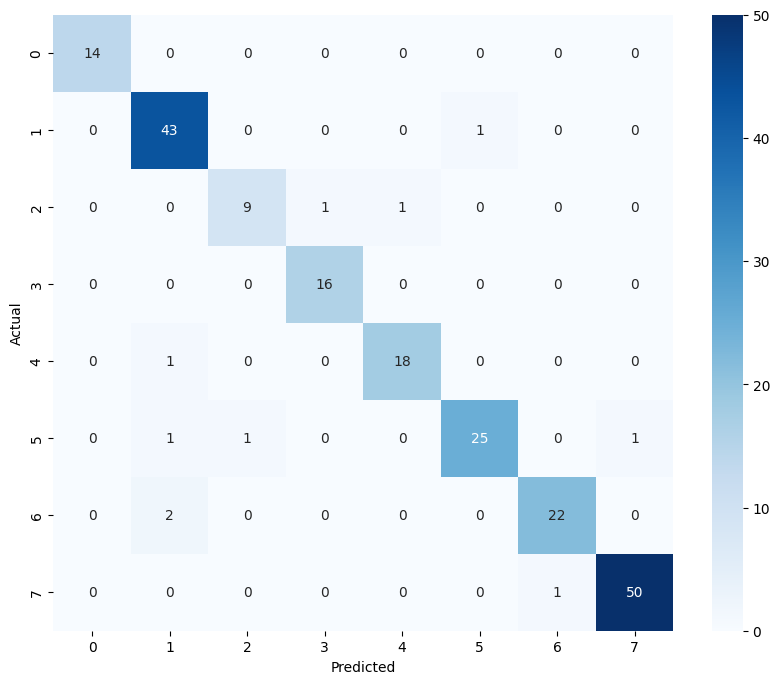

In [16]:
from tensorflow.keras.models import load_model

mc = load_model('best_model_cnnb.h5')

Y_pred = mc.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1) 
Y_true = np.argmax(Y_test, axis=1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
accuracy = accuracy_score(Y_true, Y_pred_classes)

print(f"Accuracy: {accuracy * 100:.2f}%")

colormap = 'Blues'
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap = colormap)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


### Plotting model accuracy

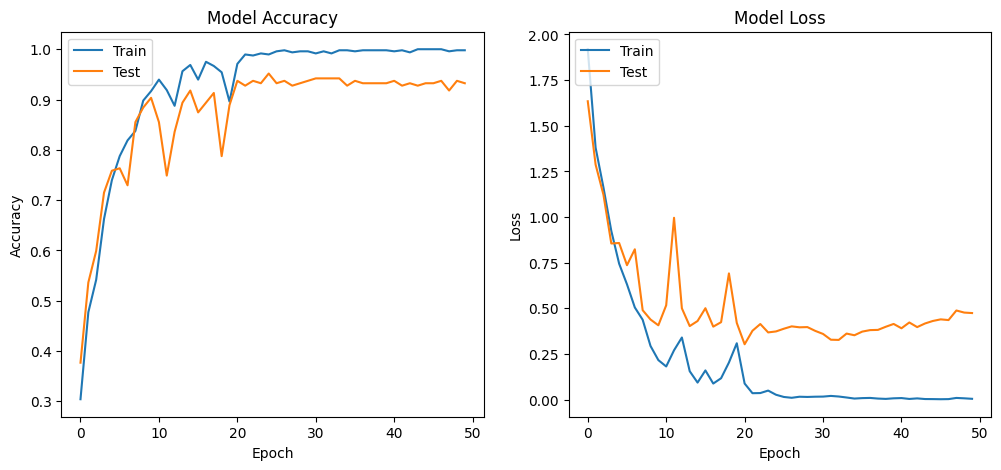

In [17]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()


### Plot ROC curves

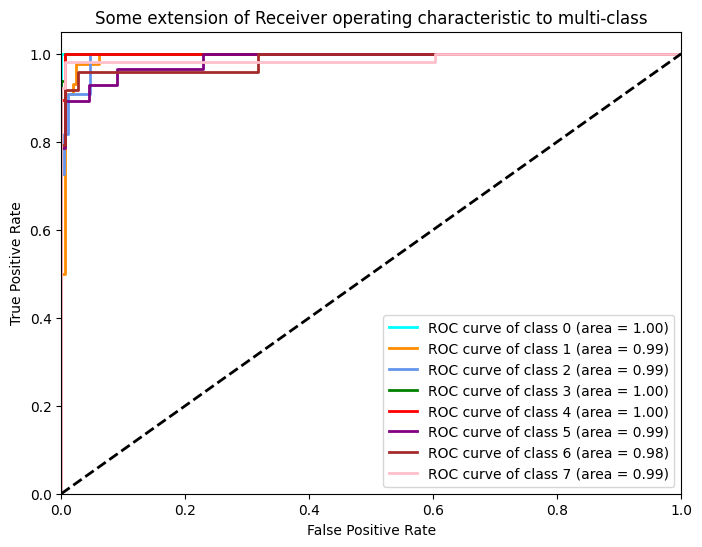

In [18]:
y_test_bin = label_binarize(Y_true, classes=[*range(num_classes)])

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], Y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), Y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(8, 6))
lw = 2
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'magenta'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()


### Precision Recall Curves

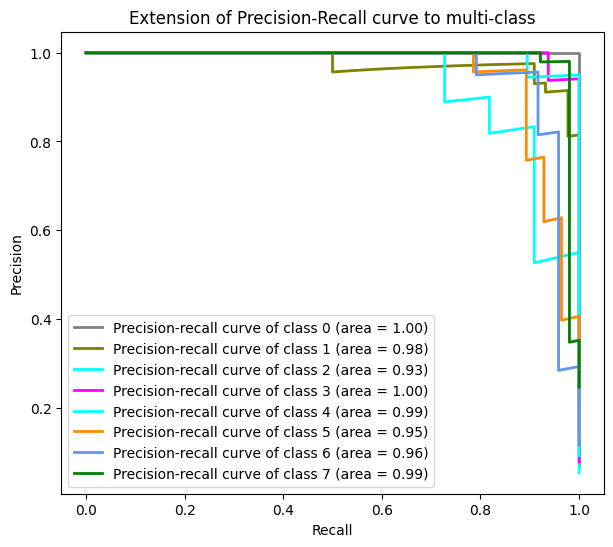

In [19]:
precision = dict()
recall = dict()
average_precision = dict()
for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], Y_pred[:, i])
    average_precision[i] = average_precision_score(y_test_bin[:, i], Y_pred[:, i])

plt.figure(figsize=(7, 6))
for i, color in zip(range(num_classes), colors):
    plt.plot(recall[i], precision[i], color=color, lw=lw,
             label='Precision-recall curve of class {0} (area = {1:0.2f})'
             ''.format(i, average_precision[i]))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower left")
plt.title('Extension of Precision-Recall curve to multi-class')
plt.show()


### Scikit-learn

In [6]:
classifiers = [
    MLPClassifier(alpha=1, 
                  max_iter=1000),
    SVC(kernel='linear',
        probability=True),
    RandomForestClassifier(n_estimators=100),
    KNeighborsClassifier(),
    LogisticRegression()
    
]

### Gridsearchcv parameters

In [7]:
parameters = []

temp = {
    'solver': ['lbfgs'], 
    'max_iter': [1000, 1200, 1500, 2000], 
    'alpha': 10.0 ** -np.arange(1, 10), 
    'hidden_layer_sizes':np.arange(10, 15),
    'activation': ['relu']
}
parameters.append(temp)

svm_params = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001]
}
parameters.append(svm_params)

rf_params = {
    'n_estimators': [10, 50, 100, 200],
    'max_features': ['auto', 'sqrt', 'log2']
}
parameters.append(rf_params)

knn_params = {
    'n_neighbors': [3, 5, 11, 19],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
parameters.append(knn_params)

logistic_params = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2']
}
parameters.append(logistic_params)

parameters

[{'solver': ['lbfgs'],
  'max_iter': [1000, 1200, 1500, 2000],
  'alpha': array([1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06, 1.e-07, 1.e-08,
         1.e-09]),
  'hidden_layer_sizes': array([10, 11, 12, 13, 14]),
  'activation': ['relu']},
 {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001]},
 {'n_estimators': [10, 50, 100, 200],
  'max_features': ['auto', 'sqrt', 'log2']},
 {'n_neighbors': [3, 5, 11, 19],
  'weights': ['uniform', 'distance'],
  'metric': ['euclidean', 'manhattan']},
 {'C': [0.001, 0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2']}]

### Run All Models

In [8]:
import time

ids = np.array(ids)    
X_train = pd.DataFrame(X_train_pca)
X_test = pd.DataFrame(X_test_pca)
Y_train = Y_train0
Y_test = Y_test0

count = 0
mean_scores = []
test_accuracies = []
confusion_matrices = {}
best_models = {}
training_times = []
prediction_times = []

for i, classifier in enumerate(classifiers):
    
    grid_search = GridSearchCV(classifier, parameters[count], n_jobs=2, cv=5)
    
    start_time = time.time()

    # Training
    grid_search.fit(X_train, Y_train)
    training_time = time.time() - start_time
    training_times.append(training_time)

    # Prediction
    start_time = time.time()
    y_pred = grid_search.predict(X_test)
    prediction_time = time.time() - start_time
    prediction_times.append(prediction_time)

    pipeline = make_pipeline(StandardScaler(), grid_search.best_estimator_)
    
    best_model = grid_search.best_estimator_
    best_model.fit(X_train, Y_train)
    best_models[f'Model_{classifier}'] = best_model

    if i == 0 :
        y_pred_mlp_pca = best_model.predict_proba(X_test)
    if i == 1 :
        y_pred_svc_pca = best_model.predict_proba(X_test)
    if i == 2 :
        y_pred_rf_pca = best_model.predict_proba(X_test)
    if i == 3 :
        y_pred_knn_pca = best_model.predict_proba(X_test)    
    if i == 4 :
        y_pred_lr_pca = best_model.predict_proba(X_test)
      
    test_accuracy = best_model.score(X_test, Y_test)
    test_accuracies.append(test_accuracy)

    print(f"Model (Best Parameters): {grid_search.best_params_}")
    print(f"Test Set Accuracy: {test_accuracy}")

    y_pred = best_model.predict(X_test)
    cm = confusion_matrix(Y_test, y_pred)
    confusion_matrices[f'Model_{classifier}'] = cm
    
    strtfdKFold = StratifiedKFold(n_splits=5)
    kfold = strtfdKFold.split(faces0, ids)
    scores = []
    for k, (train, test) in enumerate(kfold):
        pipeline.fit(faces0[train], ids[train])
        score = pipeline.score(faces0[test], ids[test])
        scores.append(score)

    mean_scores.append(np.mean(scores))
    count += 1

print('Mean results from all models:')
print(mean_scores)

Model (Best Parameters): {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': 14, 'max_iter': 1500, 'solver': 'lbfgs'}
Test Set Accuracy: 0.8357487922705314
Model (Best Parameters): {'C': 0.1, 'gamma': 1}
Test Set Accuracy: 0.821256038647343
Model (Best Parameters): {'max_features': 'sqrt', 'n_estimators': 100}
Test Set Accuracy: 0.8405797101449275
Model (Best Parameters): {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
Test Set Accuracy: 0.748792270531401
Model (Best Parameters): {'C': 0.1, 'penalty': 'l2'}
Test Set Accuracy: 0.8115942028985508
Mean results from all models:
[0.8503438061990902, 0.8517719242568497, 0.9273563947953031, 0.7978102189781022, 0.8124828096900455]


## Results

### Average accuracy on training set

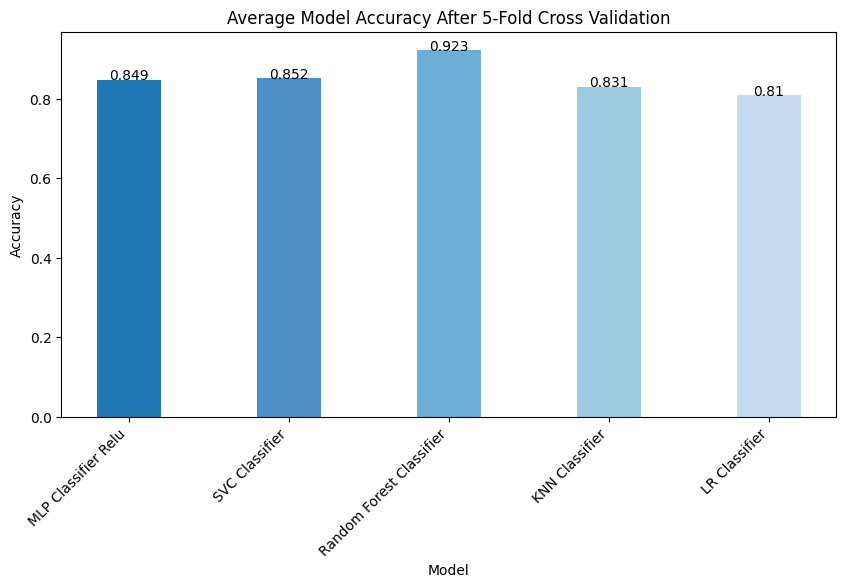

[0.8487781656616947, 0.8517719242568497, 0.9229874114037872, 0.8312387601819529, 0.8095736803131282]


In [19]:
data = {
    'MLP Classifier Relu':mean_scores[0],
    'SVC Classifier':mean_scores[1],
    'Random Forest Classifier':mean_scores[2],
    'KNN Classifier':mean_scores[3],
    'LR Classifier':mean_scores[4],
}
model_names = list(data.keys())
accuracy_values = list(data.values())
  
plt.figure(figsize=(10, 5))
plt.bar(model_names, 
        accuracy_values,  
        width = 0.4, 
        color = ['#1f77b4', '#4c8ec8', '#6baed6', '#9ecae1', '#c6dbef'])
addLabels(model_names, accuracy_values)
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Average Model Accuracy After 5-Fold Cross Validation")
plt.xticks(rotation=45, ha='right')
plt.show()

print(accuracy_values)

### Accuracies on test data

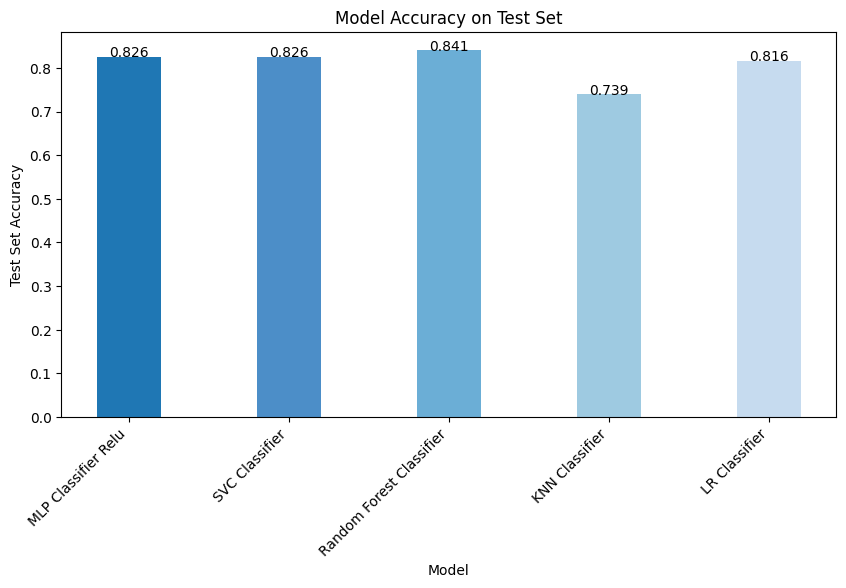

In [20]:
plt.figure(figsize=(10, 5))
plt.bar(model_names, test_accuracies, width=0.4, color=['#1f77b4', '#4c8ec8', '#6baed6', '#9ecae1', '#c6dbef'])
addLabels(model_names, test_accuracies)
plt.xlabel("Model")
plt.ylabel("Test Set Accuracy")
plt.title("Model Accuracy on Test Set")
plt.xticks(rotation=45, ha='right')
plt.show()

### Plotting training and prediction times for the models

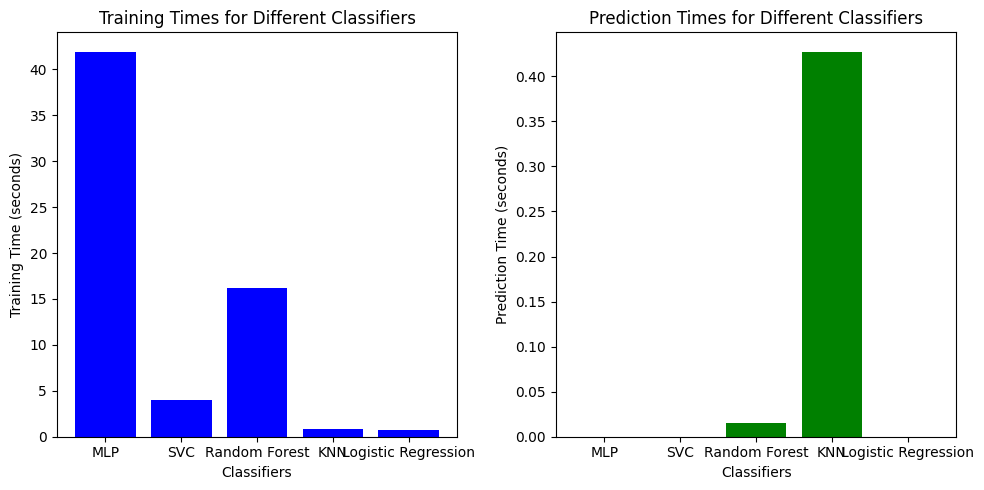

In [9]:
classifiers_names = ['MLP', 'SVC', 'Random Forest', 'KNN', 'Logistic Regression']
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.bar(classifiers_names, training_times, color='blue')
plt.xlabel('Classifiers')
plt.ylabel('Training Time (seconds)')
plt.title('Training Times for Different Classifiers')

plt.subplot(1, 2, 2)
plt.bar(classifiers_names, prediction_times, color='green')
plt.xlabel('Classifiers')
plt.ylabel('Prediction Time (seconds)')
plt.title('Prediction Times for Different Classifiers')

plt.tight_layout()
plt.show()

### Plotting confusion matrix

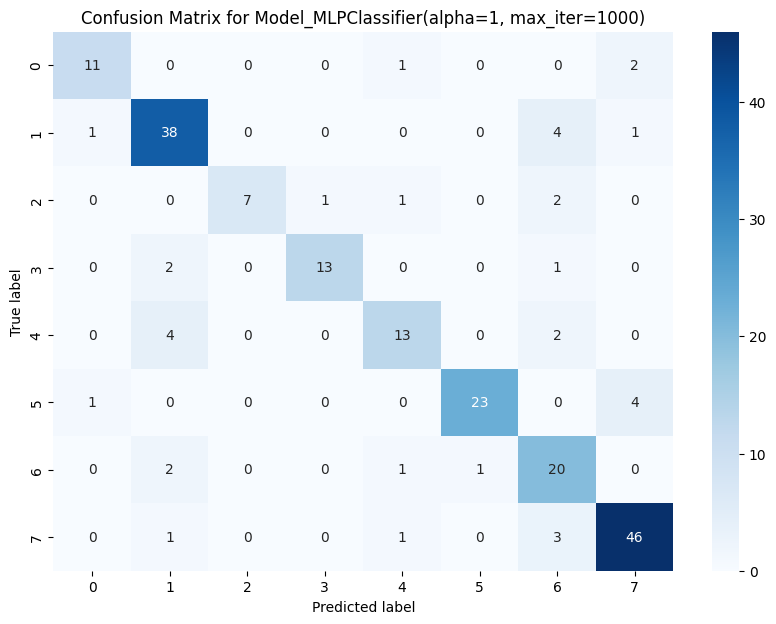

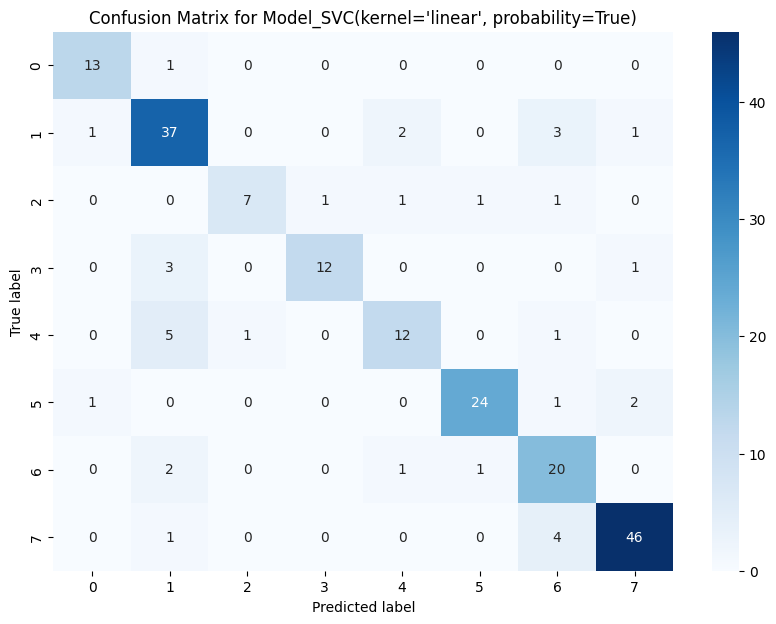

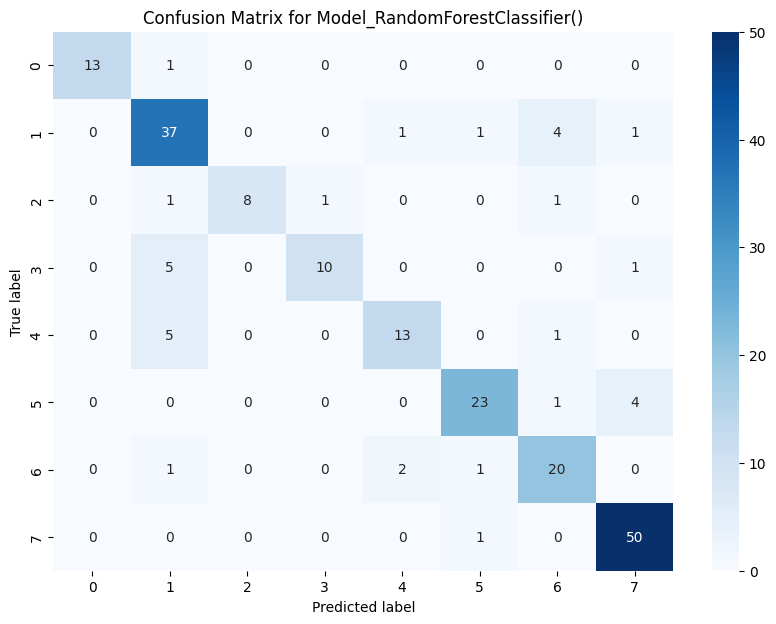

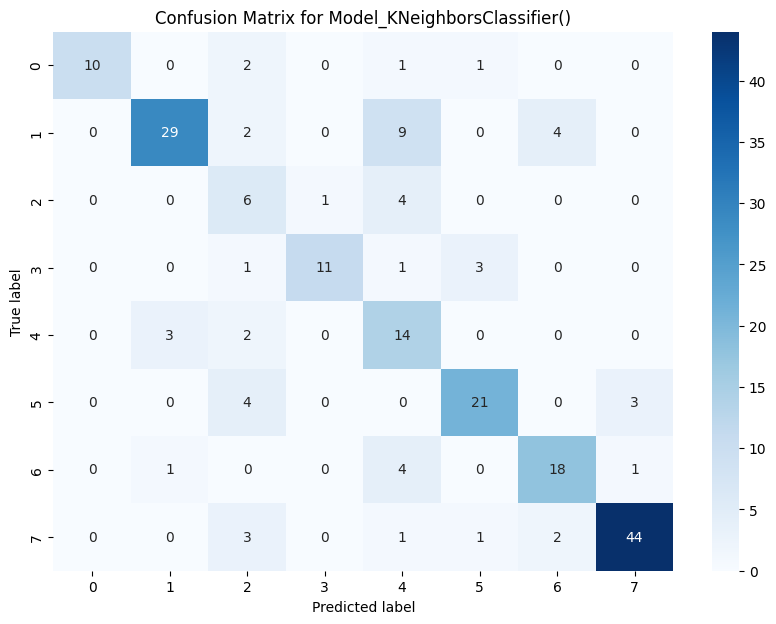

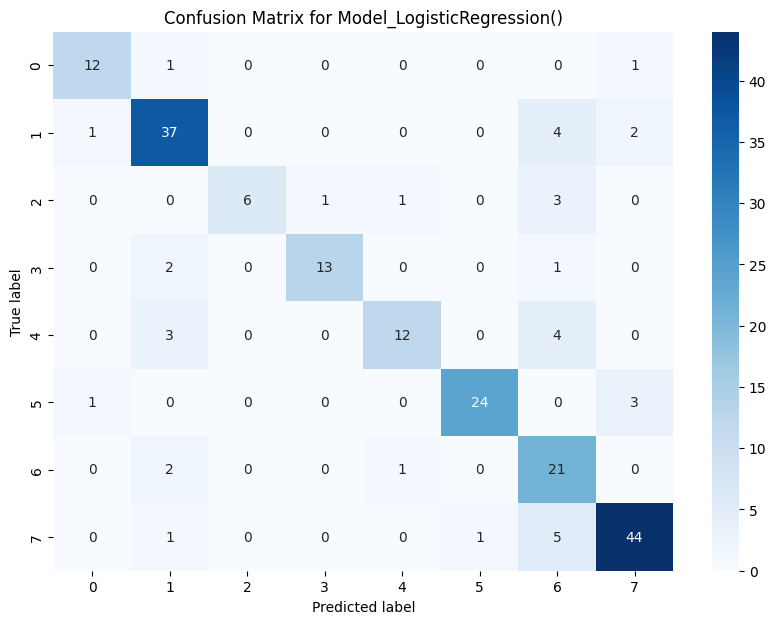

In [21]:
colormap = 'Blues'

for model_name, cm in confusion_matrices.items():
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='g', cmap=colormap)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

### Plotting ROC curves on PCA downsampled data

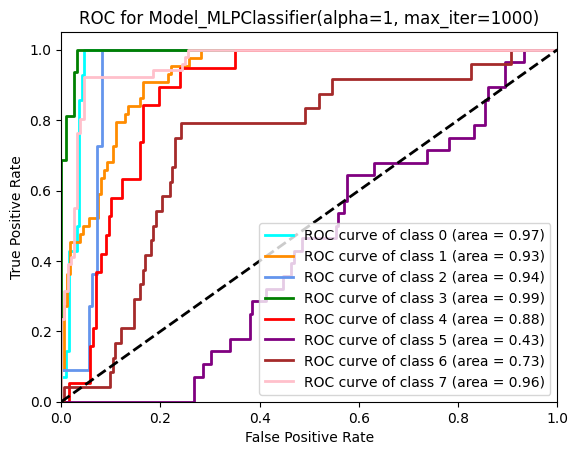

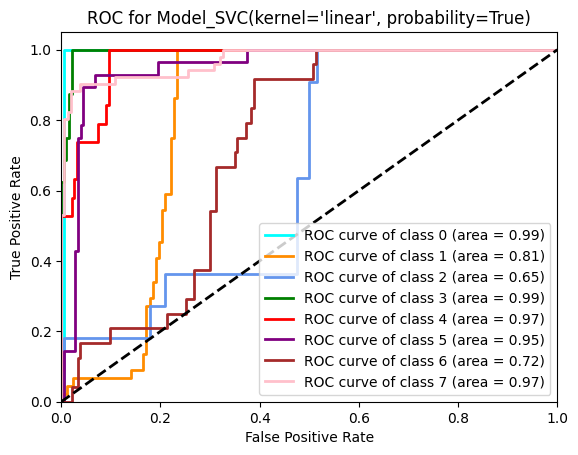

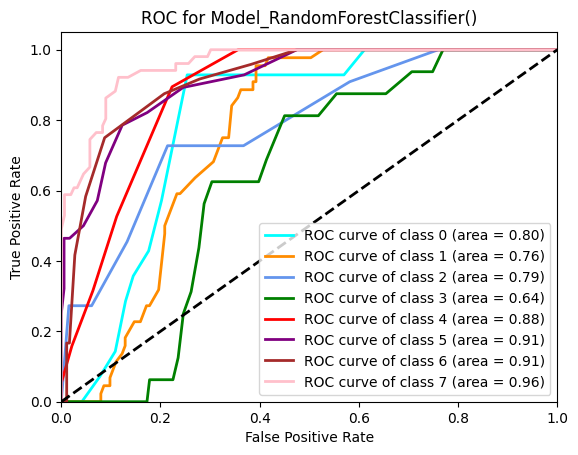

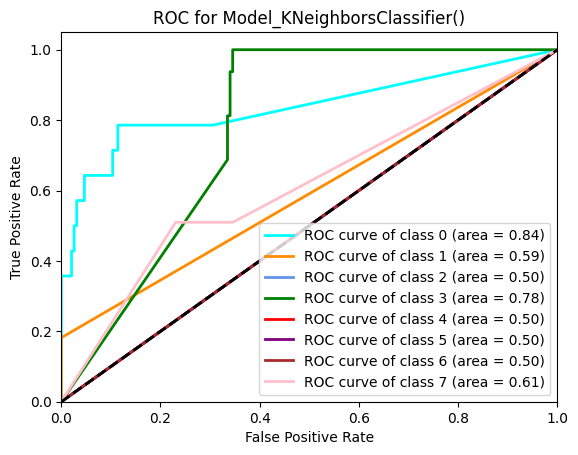

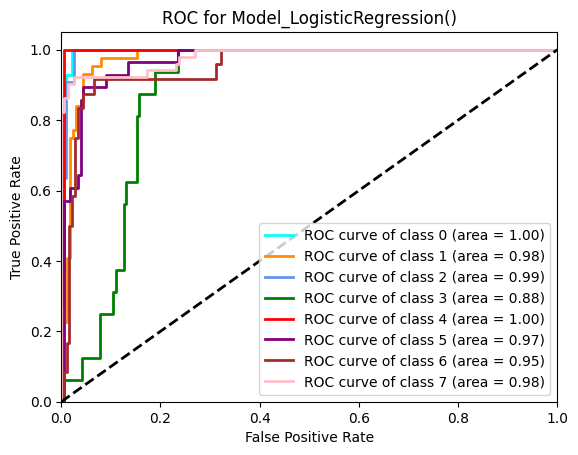

In [22]:
lb = LabelBinarizer()
Y_test_one_hot = lb.fit_transform(Y_test)

for model_name, model in best_models.items():
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(Y_test_one_hot[:, i], model.predict_proba(X_test0)[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure()
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'magenta'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC for {model_name}')
    plt.legend(loc="lower right")
    plt.show()

### Using RPCA downsampled data to train SKlearn models

In [10]:
ids = np.array(ids)    
X_train = pd.DataFrame(X_train_rpca)
X_test = pd.DataFrame(X_test_rpca)
Y_train = Y_train0
Y_test = Y_test0

count = 0
mean_scores = []
test_accuracies = []
confusion_matrices = {}
best_models = {}
training_times_rpca = []
prediction_times_rpca = []



for i, classifier in enumerate(classifiers):
    
    grid_search = GridSearchCV(classifier, parameters[count], n_jobs=2, cv=5)
    
    start_time = time.time()

    # Training
    grid_search.fit(X_train, Y_train)
    training_time = time.time() - start_time
    training_times_rpca.append(training_time)

    # Prediction
    start_time = time.time()
    y_pred = grid_search.predict(X_test)
    prediction_time = time.time() - start_time
    prediction_times_rpca.append(prediction_time)

    grid_search.fit(X_train, Y_train)
    
    pipeline = make_pipeline(StandardScaler(), grid_search.best_estimator_)


    best_model = grid_search.best_estimator_
    best_model.fit(X_train, Y_train)
    best_models[f'Model_{classifier}'] = best_model
    if i == 0 :
        y_pred_mlp = best_model.predict_proba(X_test)
    if i == 1 :
        y_pred_svc = best_model.predict_proba(X_test)
    if i == 2 :
        y_pred_rf = best_model.predict_proba(X_test)
    if i == 3 :
        y_pred_knn = best_model.predict_proba(X_test)    
    if i == 4 :
        y_pred_lr = best_model.predict_proba(X_test)
        
    test_accuracy = best_model.score(X_test, Y_test)
    test_accuracies.append(test_accuracy)

    print(f"Model (Best Parameters): {grid_search.best_params_}")
    print(f"Test Set Accuracy: {test_accuracy}")

    y_pred = best_model.predict(X_test)
    cm = confusion_matrix(Y_test, y_pred)
    confusion_matrices[f'Model_{classifier}'] = cm
    
    strtfdKFold = StratifiedKFold(n_splits=5)
    kfold = strtfdKFold.split(faces0, ids)
    scores = []
    for k, (train, test) in enumerate(kfold):
        pipeline.fit(faces0[train], ids[train])
        score = pipeline.score(faces0[test], ids[test])
        scores.append(score)

    
    mean_scores.append(np.mean(scores))
    count += 1

print('Mean results from all models:')
print(mean_scores)

Model (Best Parameters): {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': 14, 'max_iter': 1000, 'solver': 'lbfgs'}
Test Set Accuracy: 0.8599033816425121
Model (Best Parameters): {'C': 0.1, 'gamma': 1}
Test Set Accuracy: 0.8985507246376812
Model (Best Parameters): {'max_features': 'sqrt', 'n_estimators': 200}
Test Set Accuracy: 0.8502415458937198
Model (Best Parameters): {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}
Test Set Accuracy: 0.8260869565217391
Model (Best Parameters): {'C': 0.1, 'penalty': 'l2'}
Test Set Accuracy: 0.8309178743961353
Mean results from all models:
[0.8386861313868612, 0.8517719242568497, 0.9215592933460277, 0.7804083359779964, 0.8124828096900455]


### Plotting test accuracy

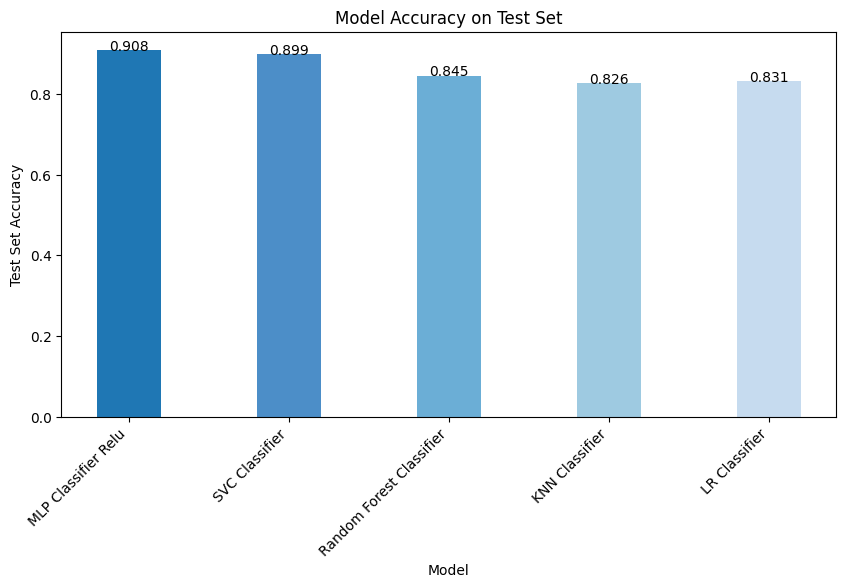

In [23]:
data = {
    'MLP Classifier Relu':mean_scores[0],
    'SVC Classifier':mean_scores[1],
    'Random Forest Classifier':mean_scores[2],
    'KNN Classifier':mean_scores[3],
    'LR Classifier':mean_scores[4],
    
}
model_names = list(data.keys())
accuracy_values = list(data.values())

plt.figure(figsize=(10, 5))
plt.bar(model_names, test_accuracies, width=0.4, color=['#1f77b4', '#4c8ec8', '#6baed6', '#9ecae1', '#c6dbef'])
addLabels(model_names, test_accuracies)
plt.xlabel("Model")
plt.ylabel("Test Set Accuracy")
plt.title("Model Accuracy on Test Set")
plt.xticks(rotation=45, ha='right')
plt.show()

### plotting training and prediction time

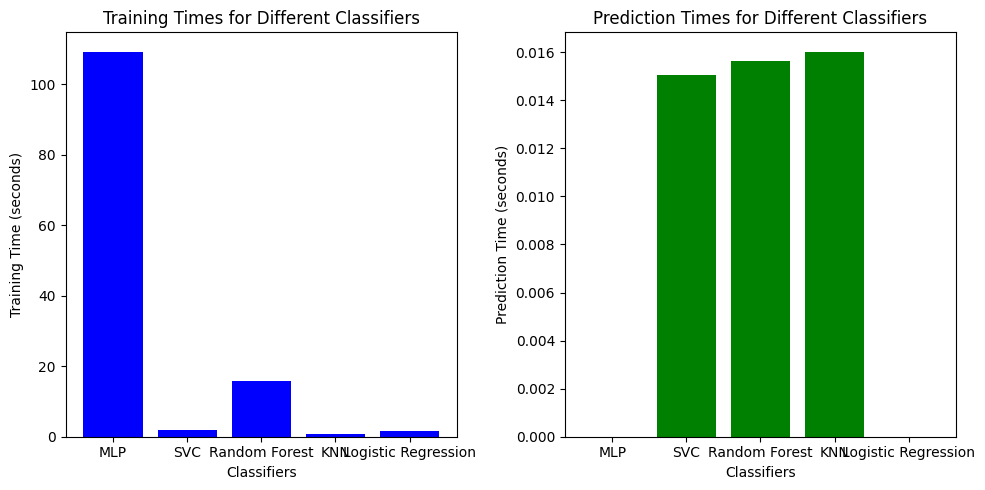

In [12]:
classifiers_names = ['MLP', 'SVC', 'Random Forest', 'KNN', 'Logistic Regression']
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.bar(classifiers_names, training_times_rpca, color='blue')
plt.xlabel('Classifiers')
plt.ylabel('Training Time (seconds)')
plt.title('Training Times for Different Classifiers')

plt.subplot(1, 2, 2)
plt.bar(classifiers_names, prediction_times_rpca, color='green')
plt.xlabel('Classifiers')
plt.ylabel('Prediction Time (seconds)')
plt.title('Prediction Times for Different Classifiers')

plt.tight_layout()
plt.show()

### Confusion matrix for Sklearn model on RPCA downsampled dataset

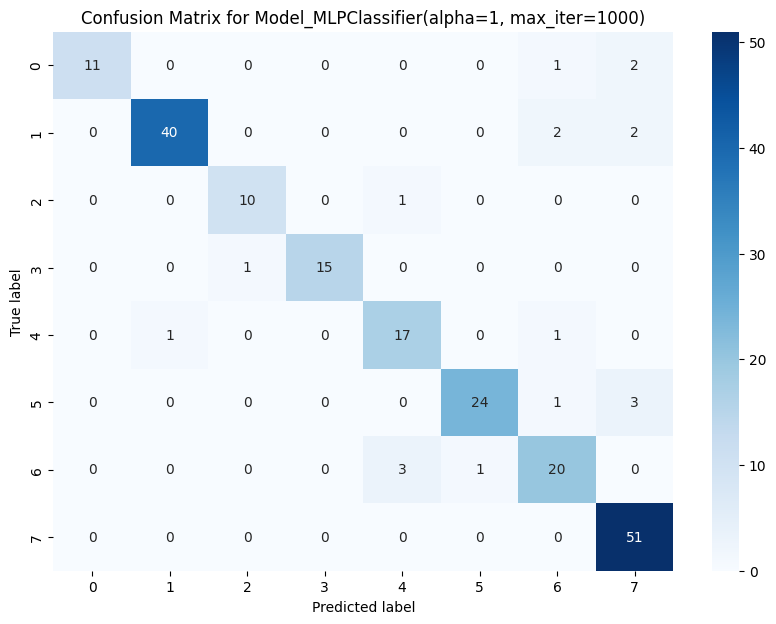

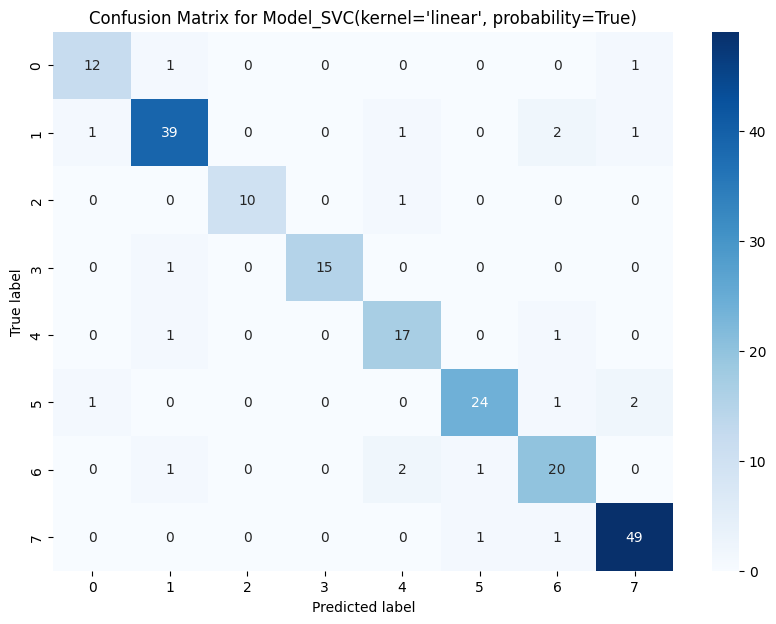

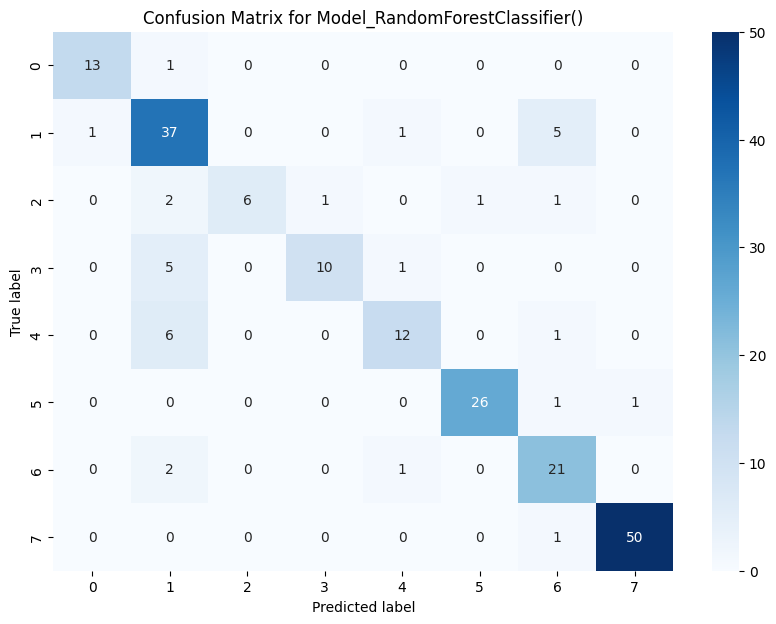

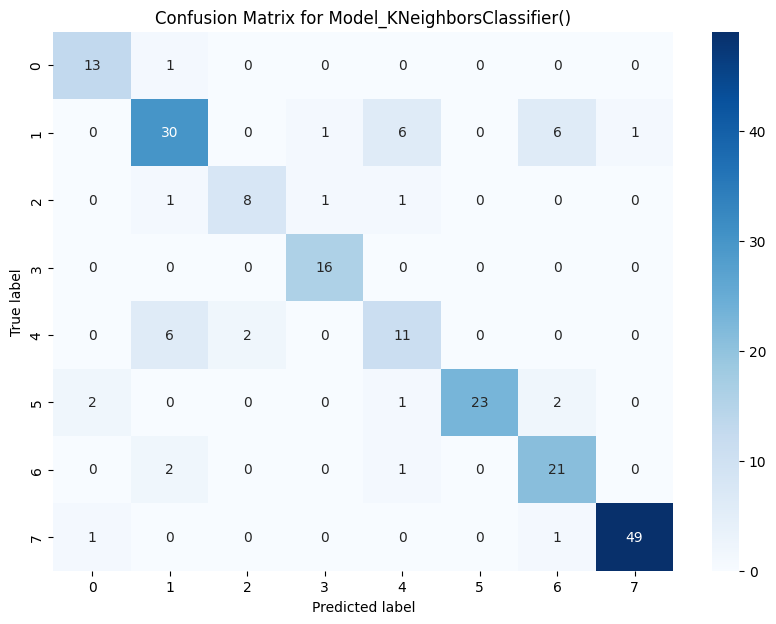

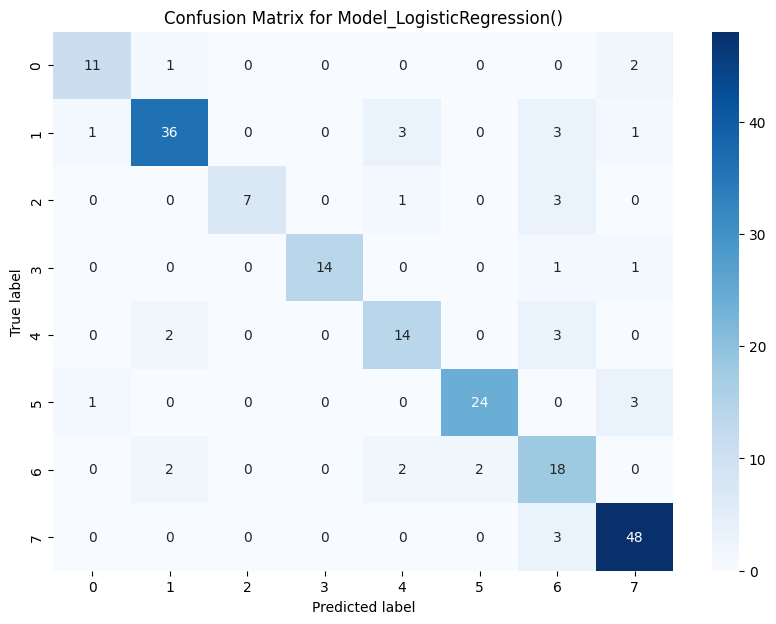

In [24]:
colormap = 'Blues'

for model_name, cm in confusion_matrices.items():
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='g', cmap=colormap)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

### ROC Curvers for the SKlearn models on RPCA downsampled dataset

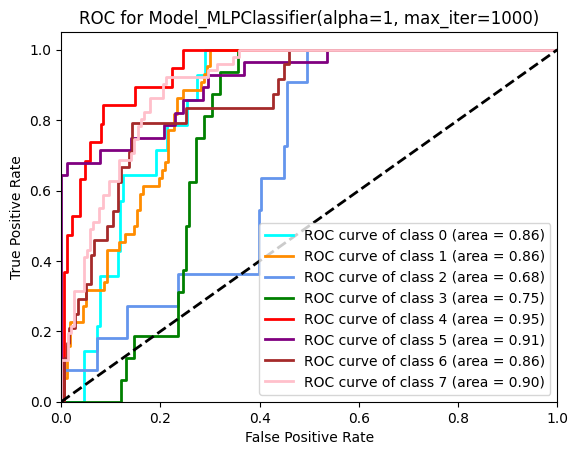

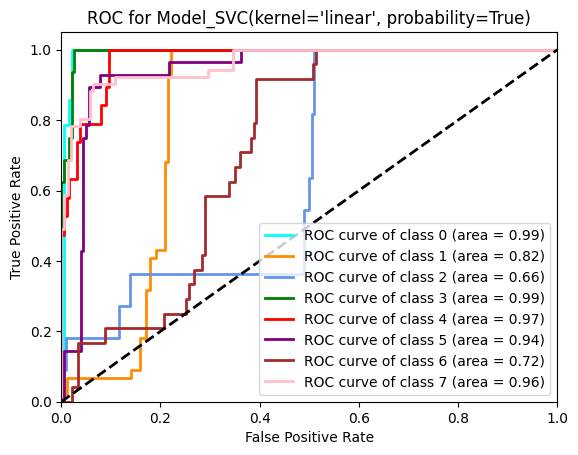

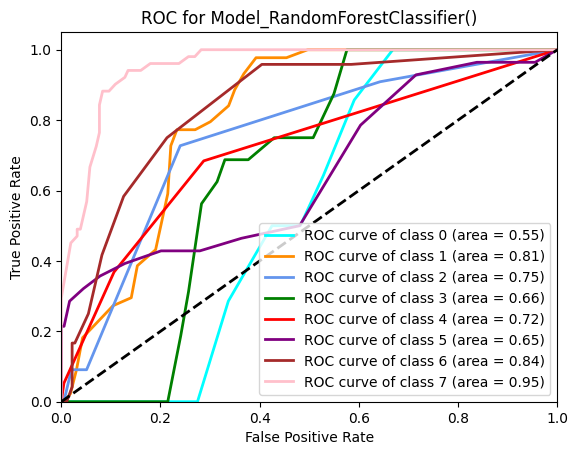

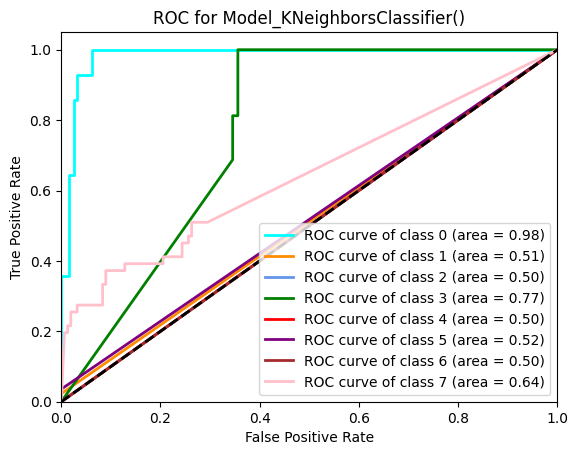

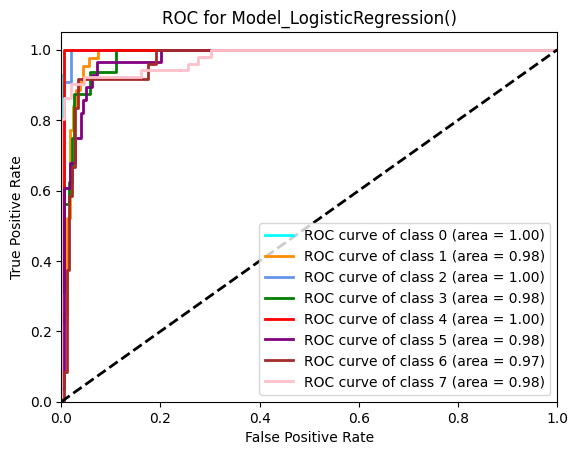

In [25]:
lb = LabelBinarizer()
Y_test_one_hot = lb.fit_transform(Y_test)

for model_name, model in best_models.items():
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(Y_test_one_hot[:, i], model.predict_proba(X_test0)[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure()
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'magenta'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC for {model_name}')
    plt.legend(loc="lower right")
    plt.show()

### Ensemble Methods

In [26]:
X_train, X_test, Y_train, Y_test = train_test_split(face_images, labels, test_size=0.3, random_state=42)
model_cnn_best = load_model('best_model_cnnb.h5')
Y_pred_cnn = model_cnn_best.predict(X_test)
average_pred = (Y_pred_cnn + y_pred_svc)/ 2
final_pred_classes = np.argmax(average_pred, axis=1)
Y_test_classes = np.argmax(Y_test, axis=1)

7/7 [==============================] - 1s 62ms/step


###  Confusion matrix for ensemble model

Ensemble Model Accuracy: 0.9468599033816425


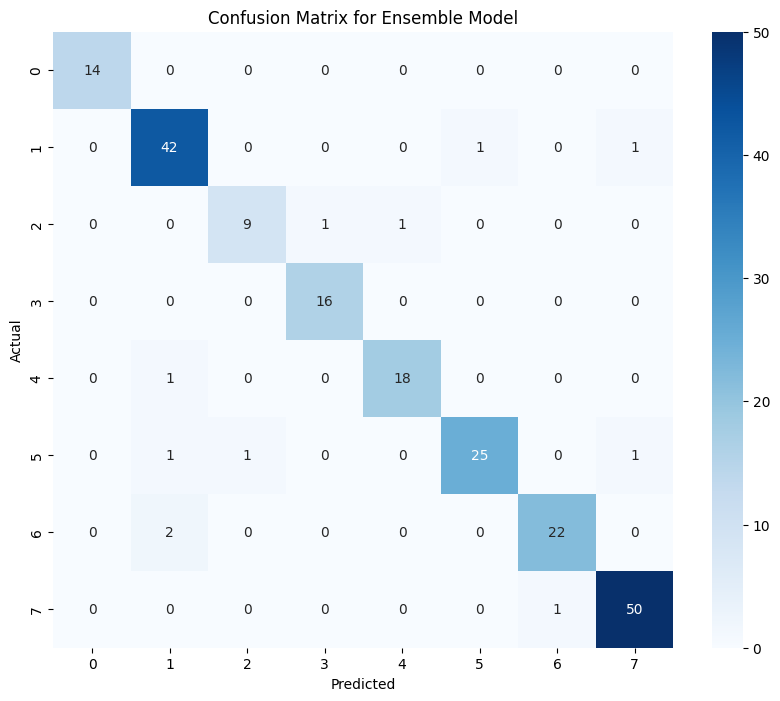

In [53]:
ensemble_accuracy = np.mean(final_pred_classes == Y_test_classes)
print(f'Ensemble Model Accuracy: {ensemble_accuracy}')

ensemble_confusion_mtx = confusion_matrix(Y_test_classes, final_pred_classes)

plt.figure(figsize=(10,8))
sns.heatmap(ensemble_confusion_mtx, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Ensemble Model')
plt.show()

<center>  End of Notebook. Thank you for viewing our project!